In [7]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sympy import zeros, Matrix, symbols
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import os
import pickle

# Import scenario properties
with open(os.path.join(os.getcwd(), '../scenario-properties-baseline.pkl'), 'rb') as f:
    scen_properties = pickle.load(f)

In [8]:
T = pd.read_csv(r'C:\Users\IT\Documents\UCL\pyssem\pyssem\utils\launch\data\x0_launch_repeatlaunch_2018to2022_megaconstellationLaunches_Constellations.csv')
# Read the data from the CSV file

def julian_to_datetime(julian_date):
    # Julian Date for Unix epoch (1970-01-01)
    JULIAN_EPOCH = 2440587.5
    try:
        # Calculate the number of days from the Unix epoch
        days_from_epoch = julian_date - JULIAN_EPOCH
        # Create a datetime object for the Unix epoch and add the calculated days
        unix_epoch = datetime(1970, 1, 1)
        result_date = unix_epoch + timedelta(days=days_from_epoch)
        return result_date
    except OverflowError as e:
        # Handle dates that are out of range
        print(f"Date conversion error: {e}")
        return None
    
def define_object_class(T):
    """
    Define the object class of each object in the traffic model.
    Adds them to a new column named "obj_type" or overwrites the existing column.

    :param T: list of launches
    :type T: pandas.DataFrame
    """

    T['obj_class'] = "Unknown"

    # Classify Rocket Bodies
    T.loc[T['obj_type'] == 1, 'obj_class'] = "Rocket Body"

    # Classify Satellites
    T.loc[(T['obj_type'] == 2) & (T['stationkeeping'] != 0) & (T['stationkeeping'] < 5), 'obj_class'] = "Station-keeping Satellite"
    T.loc[(T['obj_type'] == 2) & (T['stationkeeping'] == 0), 'obj_class'] = "Non-station-keeping Satellite"
    T.loc[(T['obj_type'] == 2) & (T['stationkeeping'] == 5), 'obj_class'] = "Coordinated Satellite"
    T.loc[(T['obj_type'] == 2) & (T['stationkeeping'] == 6), 'obj_class'] = "Candidate Satellite"

    # Classify Debris
    T.loc[T['obj_type'].isin([3, 4]), 'obj_class'] = "Debris"

    # Count unclassified rows
    unclassed_rows = (T['obj_class'] == "Unknown").sum()
    if unclassed_rows > 0:
        print(f'\t{unclassed_rows} Unclassified rows remain.')

    return T

    
T['epoch_start_datime'] = T['epoch_start'].apply(lambda x: julian_to_datetime(x))

if 'obj_class' not in T.columns:
    T = define_object_class(T)  # Make sure this function is defined and imported

# Calculate Apogee, Perigee, and Altitude
T['apogee'] = T['sma'] * (1 + T['ecc'])
T['perigee'] = T['sma'] * (1 - T['ecc'])
T['alt'] = (T['apogee'] + T['perigee']) / 2 - scen_properties.re

In [9]:
def find_alt_bin(altitude, scen_properties):
    # Convert altitude ranges to numpy arrays for vectorized operations
    lower = np.array(scen_properties.R0[:-1])
    upper = np.array(scen_properties.R0[1:])
    
    # Create a boolean array where True indicates altitude is within the shell bounds
    shell_logic = (lower < altitude) & (altitude <= upper)
    
    # Find the index (or indices) where shell_logic is True
    shell_indices = np.where(shell_logic)[0]
    
    # Return the first index if found, otherwise return NaN
    shell_index = shell_indices[0] + 1 if shell_indices.size > 0 else np.nan
    return shell_index
def find_mass_bin(mass, scen_properties, species_cell):
    """
    Find the mass bin for a given mass.

    :param mass: Mass of the object in kg
    :type mass: float
    :param scen_properties: The scenario properties object
    :type scen_properties: ScenarioProperties
    :param species_cell: The species cell to find the mass bin for
    :type species_cell: Species
    :return: The mass bin for the given mass
    :rtype: int
    """
    for species in species_cell:
        if species.mass_lb <= mass < species.mass_ub:
            return species.sym_name
    
    return None



# Map species type based on object class
species_dict = {"Non-station-keeping Satellite": "Sns",
                "Rocket Body": "B",
                "Station-keeping Satellite": "Su",
                "Coordinated Satellite": "S",
                "Debris": "N",
                "Candidate Satellite": "C"}

T['species_class'] = T['obj_class'].map(species_dict)

# Initialize an empty DataFrame for new data
T_new = pd.DataFrame()

# Loop through object classes and assign species based on mass
for obj_class in T['obj_class'].unique():
        species_class = species_dict.get(obj_class)
        if species_class in scen_properties.species_cells:
                # if species class is candidate satellite, continue
                if len(scen_properties.species_cells[species_class]) == 1:
                        T_obj_class = T[T['obj_class'] == obj_class].copy()
                        T_obj_class['species'] = scen_properties.species_cells[species_class][0].sym_name
                        T_new = pd.concat([T_new, T_obj_class])
                else:
                        species_cells = scen_properties.species_cells[species_class]
                        T_obj_class = T[T['obj_class'] == obj_class].copy()
                        T_obj_class['species'] = T_obj_class['mass'].apply(find_mass_bin, args=(scen_properties, species_cells)) 
                        T_new = pd.concat([T_new, T_obj_class])

# Assign objects to corresponding altitude bins
T_new['alt_bin'] = T_new['alt'].apply(find_alt_bin, args=(scen_properties,))


# Filter T_new to include only species present in scen_properties
T_new = T_new[T_new['species_class'].isin(scen_properties.species_cells.keys())]

# Initial population
x0_all = T_new[T_new['epoch_start_datime'] < scen_properties.start_date]
print(len(x0_all))

x0 = x0_all[x0_all['alt'] <= scen_properties.max_altitude]
print(len(x0))

# Create a pivot table, keep alt_bin
df = x0.pivot_table(index='alt_bin', columns='species', aggfunc='size', fill_value=0)

# Create a new data frame with column names like scenario_properties.species_sym_names and rows of length n_shells
x0_summary = pd.DataFrame(index=range(scen_properties.n_shells), columns=scen_properties.species_names).fillna(0)
x0_summary.index.name = 'alt_bin'

# Merge the two dataframes
for column in df.columns:
    if column in x0_summary.columns:
        x0_summary[column] = df[column]

# fill NaN with 0
x0_summary.fillna(0, inplace=True)
print(x0_summary.sum().sum())

# # Future Launch Model
flm_steps = pd.DataFrame()

time_increment_per_step = scen_properties.simulation_duration / scen_properties.steps

time_steps = [scen_properties.start_date + timedelta(days=365.25 * time_increment_per_step * i) 
            for i in range(scen_properties.steps + 1)]    

for start, end in zip(time_steps[:-1], time_steps[1:]):
    flm_step = T_new[(T_new['epoch_start_datime'] >= start) & (T_new['epoch_start_datime'] < end)]
    print(f"Step: {start} - {end}, Objects: {flm_step.shape[0]}")
    flm_summary = flm_step.groupby(['alt_bin', 'species']).size().unstack(fill_value=0)

    # all objects aren't always in shells, so you need to these back in. 
    flm_summary = flm_summary.reindex(range(0, scen_properties.n_shells), fill_value=0)

    flm_summary.reset_index(inplace=True)
    flm_summary.rename(columns={'index': 'alt_bin'}, inplace=True)

    flm_summary['epoch_start_date'] = start # Add the start date to the table for reference
    flm_steps = pd.concat([flm_steps, flm_summary])

#      alt_bin species
# 242     10.0    None
# 257     11.0    None
# 262     14.0    None


13199
12143
0
Step: 2022-01-03 00:00:00 - 2023-01-03 06:00:00, Objects: 2980
Step: 2023-01-03 06:00:00 - 2024-01-03 12:00:00, Objects: 279
Step: 2024-01-03 12:00:00 - 2025-01-02 18:00:00, Objects: 275
Step: 2025-01-02 18:00:00 - 2026-01-03 00:00:00, Objects: 295
Step: 2026-01-03 00:00:00 - 2027-01-03 06:00:00, Objects: 299
Step: 2027-01-03 06:00:00 - 2028-01-03 12:00:00, Objects: 283
Step: 2028-01-03 12:00:00 - 2029-01-02 18:00:00, Objects: 282
Step: 2029-01-02 18:00:00 - 2030-01-03 00:00:00, Objects: 278
Step: 2030-01-03 00:00:00 - 2031-01-03 06:00:00, Objects: 286
Step: 2031-01-03 06:00:00 - 2032-01-03 12:00:00, Objects: 287
Step: 2032-01-03 12:00:00 - 2033-01-02 18:00:00, Objects: 299
Step: 2033-01-02 18:00:00 - 2034-01-03 00:00:00, Objects: 291
Step: 2034-01-03 00:00:00 - 2035-01-03 06:00:00, Objects: 274
Step: 2035-01-03 06:00:00 - 2036-01-03 12:00:00, Objects: 286
Step: 2036-01-03 12:00:00 - 2037-01-02 18:00:00, Objects: 282
Step: 2037-01-02 18:00:00 - 2038-01-03 00:00:00, Object

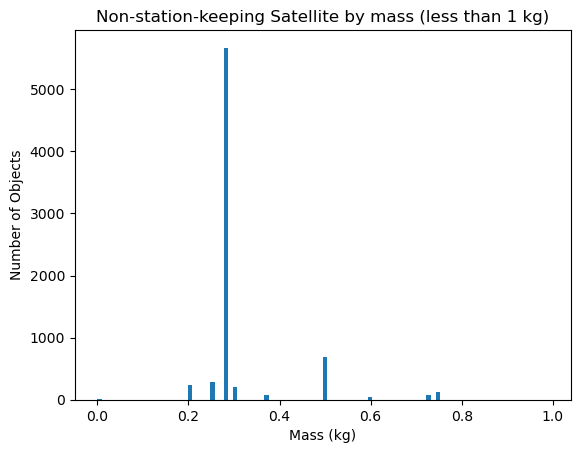

In [14]:
# show the rows in in T that have the same adept_id as the rows in lost 
test = T[T['obj_class'] == "Non-station-keeping Satellite"]
test = test[test['mass'] < 1]

# plot a histogram of the mass of the objects
plt.hist(test['mass'], bins=100)
plt.xlabel('Mass (kg)')
plt.ylabel('Number of Objects')
plt.title('Non-station-keeping Satellite by mass (less than 1 kg)')
plt.show()

In [10]:
import scipy.io
import pandas as pd
import numpy as np

def matsats2ASEM(matsats):
    radiusearthkm = 6378.137
    
    # Column indices in matsats array
    idx_a = 0
    idx_ecco = 1
    idx_inclo = 2
    idx_nodeo = 3
    idx_argpo = 4
    idx_mo = 5
    idx_bstar = 6
    idx_mass = 7
    idx_radius = 8
    idx_error = 9
    idx_controlled = 10
    idx_a_desired = 11
    idx_missionlife = 12
    idx_constel = 13
    idx_date_created = 14
    idx_launch_date = 15
    idx_objectclass = 16
    idx_ID = 17
    
    # Initialize the DataFrame
    asem = pd.DataFrame()

    # Calculate ASEM values
    asem['sma'] = matsats[:, idx_a] * radiusearthkm  # SMA [km]
    asem['ecc'] = matsats[:, idx_ecco]              # Ecc [-]
    asem['inc'] = np.degrees(matsats[:, idx_inclo])  # Inc [deg]
    asem['raan'] = np.degrees(matsats[:, idx_nodeo]) # RAAN [deg]
    asem['aop'] = np.degrees(matsats[:, idx_argpo])  # AOP [deg]
    asem['ma'] = np.degrees(matsats[:, idx_mo])     # Mean Anomaly [deg]
    asem['mass'] = matsats[:, idx_mass]             # Mass [kg]
    asem['size'] = matsats[:, idx_radius] * 2       # Diameter [m]
    asem['area'] = np.pi * matsats[:, idx_radius]**2 # Area [m^2]

    # Object type flag
    asem['obj_type'] = 0
    asem.loc[matsats[:, idx_objectclass] == 5, 'obj_type'] = 1  # Rocket Body
    asem.loc[matsats[:, idx_objectclass] == 1, 'obj_type'] = 2  # Payload

    # Disposal option flag
    asem['disp_option'] = 0

    # Stationkeeping flag
    asem['stationkeeping'] = 0
    asem.loc[matsats[:, idx_controlled] == 1, 'stationkeeping'] = 3  # Controlled

    # Epochs
    asem['epoch_start'] = matsats[:, idx_launch_date]  # Start or launch date [JD]
    asem['epoch_end'] = asem['epoch_start'] + matsats[:, idx_missionlife] * 365.2425  # [JD]

    # Object ID
    asem['adept_id'] = matsats[:, idx_ID]

    # Weighting Factor
    asem['weight'] = 1

    return asem

# Load the .mat file
mat_data = scipy.io.loadmat(r'D:\ucl\pyssem\pyssem\utils\launch\data\x0.mat')

# Access the initial_data array
initial_data = mat_data['initial_data']

# Convert to Pandas DataFrame
df = pd.DataFrame(initial_data)

# Apply the matsats2ASEM function
asem_df = matsats2ASEM(df.values)

# find the number of objects with a mass of 0
no_mass = asem_df[asem_df['mass'] == 0]
no_mass

asem_df

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\ucl\\pyssem\\pyssem\\utils\\launch\\data\\x0.mat'

In [33]:
# sum all values across scenario_properties.x0
scen_properties.FLM_steps.epoch_start_date.unique()

<DatetimeArray>
['2022-01-03 00:00:00', '2022-07-04 15:00:00', '2023-01-03 06:00:00',
 '2023-07-04 21:00:00', '2024-01-03 12:00:00', '2024-07-04 03:00:00',
 '2025-01-02 18:00:00', '2025-07-04 09:00:00', '2026-01-03 00:00:00',
 '2026-07-04 15:00:00',
 ...
 '2117-01-03 18:00:00', '2117-07-05 09:00:00', '2118-01-04 00:00:00',
 '2118-07-05 15:00:00', '2119-01-04 06:00:00', '2119-07-05 21:00:00',
 '2120-01-04 12:00:00', '2120-07-05 03:00:00', '2121-01-03 18:00:00',
 '2121-07-05 09:00:00']
Length: 200, dtype: datetime64[ns]

In [31]:
# Matlab's x0
mat_x0 = pd.read_csv(r'D:\ucl\pyssem\pyssem\utils\launch\data\x0.csv')
mat_x0.sum().sum()

13983

In [18]:
x0

,adept_id,epoch_start,sma,ecc,inc,raan,aop,ma,epoch_end,obj_type,...,size,weight,epoch_start_datime,obj_class,apogee,perigee,alt,species_class,species,alt_bin
16,85,2437346.5,7171.463,0.036446,38.7679,118.0948,238.3752,118.0948,2437346.50,3,...,0.133838,1,1961-02-16,Debris,7432.837009,6910.088991,793.3264,N,N_4kg,NaN
18,115,2437025.5,6991.474,0.003327,48.1642,341.6383,18.5737,341.6383,2437025.50,3,...,0.720050,1,1960-04-01,Debris,7014.733935,6968.214065,613.3374,N,N_16.9kg,NaN
22,119,2437479.5,7190.495,0.009849,66.7291,266.5961,94.6391,266.5961,2437479.50,3,...,0.532579,1,1961-06-29,Debris,7261.311309,7119.678691,812.3584,N,N_16.9kg,NaN
23,120,2437479.5,7183.239,0.011858,66.7061,159.1377,200.4942,159.1377,2437479.50,3,...,1.671158,1,1961-06-29,Debris,7268.417130,7098.060870,805.1024,N,N_16.9kg,NaN
24,121,2437479.5,7272.697,0.009210,66.7484,189.1401,171.1336,189.1401,2437479.50,3,...,1.280546,1,1961-06-29,Debris,7339.679994,7205.714006,894.5604,N,N_16.9kg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16092,50504,2459575.5,7307.880,0.000257,87.5508,311.6144,54.2532,311.6144,2462497.44,2,...,1.916695,1,2021-12-27,Station-keeping Satellite,7309.761048,7305.998952,929.7434,Su,Su,NaN
16102,50572,2459577.5,6864.352,0.001058,88.9876,164.5848,314.7239,164.5848,2462499.44,2,...,1.613753,1,2021-12-29,Station-keeping Satellite,6871.612425,6857.091575,486.2154,Su,Su,NaN
16103,50573,2459577.5,6864.359,0.001007,88.9877,46.5605,313.4806,46.5605,2462499.44,2,...,1.613753,1,2021-12-29,Station-keeping Satellite,6871.269350,6857.448650,486.2224,Su,Su,NaN
16390,51288,2459295.5,6915.106,0.001749,97.5110,184.5909,175.5479,184.5909,2462217.44,2,...,0.533092,1,2021-03-22,Station-keeping Satellite,6927.201212,6903.010788,536.9694,Su,Su,NaN


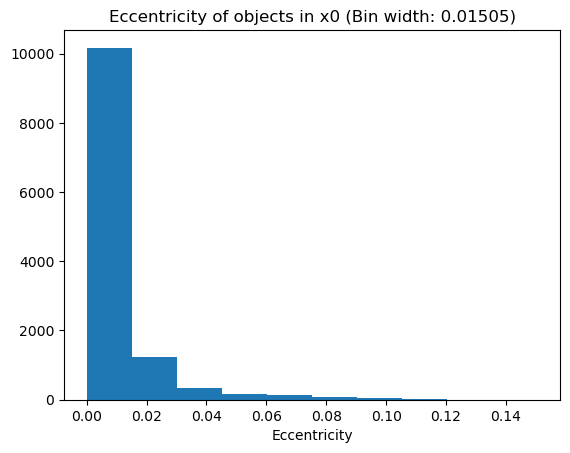

[[ 0.0000  0.0151  0.8374]
 [ 0.0151  0.0301  0.1010]
 [ 0.0301  0.0452  0.0278]
 [ 0.0452  0.0602  0.0129]
 [ 0.0602  0.0753  0.0101]
 [ 0.0753  0.0903  0.0063]
 [ 0.0903  0.1054  0.0030]
 [ 0.1054  0.1204  0.0011]
 [ 0.1204  0.1355  0.0003]
 [ 0.1355  0.1505  0.0001]]


In [40]:
# craete a histogram on the ecc column of x0
# Calculate bin width
bin_width = (x0['ecc'].max() - x0['ecc'].min()) / 10

plt.hist(x0['ecc'], bins=10)
plt.xlabel('Eccentricity')
plt.title(f'Eccentricity of objects in x0 (Bin width: {bin_width:.5f})')  # Adjust the number of decimal places as needed
plt.show()

# Set print options
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

# Calculate histogram
counts, bin_edges = np.histogram(x0['ecc'], bins=10)

# Normalize the counts
counts_normalized = counts / counts.sum()

# Create an array with the lower bin edge, upper bin edge, and normalized count for each bin
hist_data = np.array([(bin_edges[i], bin_edges[i+1], counts_normalized[i]) for i in range(len(counts))])

# Print the array
print(hist_data)


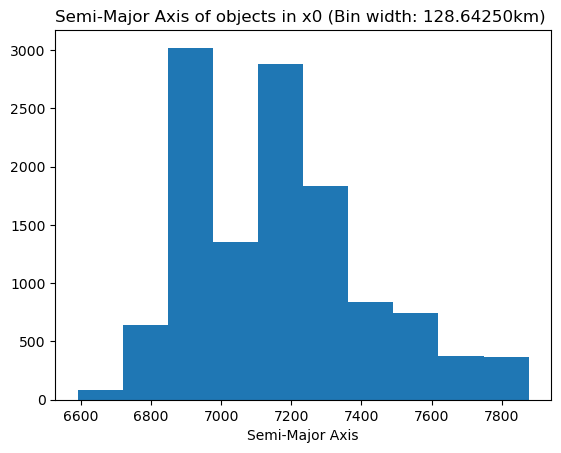

[[ 6590.6330  6719.2755  0.0072]
 [ 6719.2755  6847.9180  0.0526]
 [ 6847.9180  6976.5605  0.2488]
 [ 6976.5605  7105.2030  0.1112]
 [ 7105.2030  7233.8455  0.2376]
 [ 7233.8455  7362.4880  0.1514]
 [ 7362.4880  7491.1305  0.0688]
 [ 7491.1305  7619.7730  0.0615]
 [ 7619.7730  7748.4155  0.0310]
 [ 7748.4155  7877.0580  0.0301]]


In [41]:
# craete a histogram on the ecc column of x0
# Calculate bin width
bin_width = (x0['sma'].max() - x0['sma'].min()) / 10

plt.hist(x0['sma'], bins=10)
plt.xlabel('Semi-Major Axis')
plt.title(f'Semi-Major Axis of objects in x0 (Bin width: {bin_width:.5f}km) ')  # Adjust the number of decimal places as needed
plt.show()

np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

# Calculate histogram
counts, bin_edges = np.histogram(x0['sma'], bins=10)

# Normalize the counts
counts_normalized = counts / counts.sum()

# Create an array with the lower bin edge, upper bin edge, and normalized count for each bin
hist_data = np.array([(bin_edges[i], bin_edges[i+1], counts_normalized[i]) for i in range(len(counts))])

# Print the array
print(hist_data)


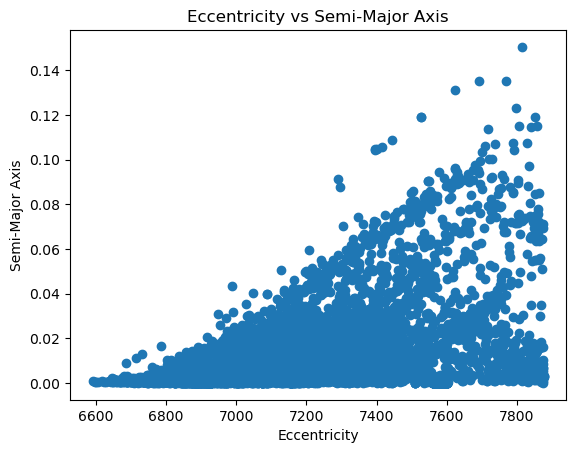

In [54]:
# create a scatter plot of the ecc and sma
plt.scatter( x0['sma'], x0['ecc'])
plt.xlabel('Eccentricity')
plt.ylabel('Semi-Major Axis')
plt.title('Eccentricity vs Semi-Major Axis')
plt.show()

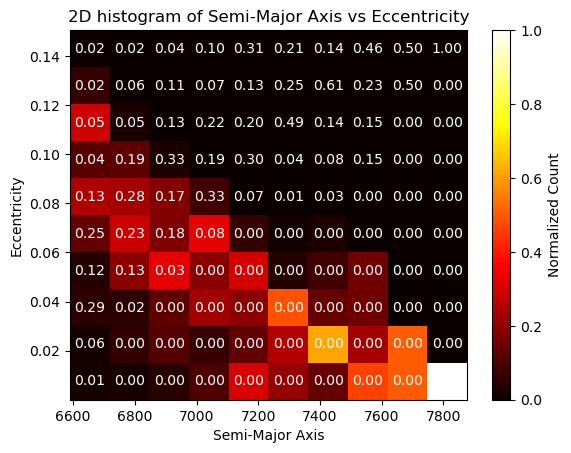

In [58]:
# Calculate the x and y values for the bins
x_bins = np.linspace(x0['sma'].min(), x0['sma'].max(), 11)
y_bins = np.linspace(x0['ecc'].min(), x0['ecc'].max(), 11)

sma = x0['sma']
ecc = x0['ecc']

# Create 2D histogram and get the counts and x and y bin edges
counts, xedges, yedges = np.histogram2d(sma, ecc, bins=[x_bins, y_bins])

# Normalize the counts so that each column adds up to 1
counts_normalized = counts / counts.sum(axis=0, keepdims=True)

# Create the 2D histogram plot with the correct origin
plt.imshow(counts_normalized, origin='upper', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')

# Add text in each bin
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), f'{counts_normalized[j, i]:.2f}', color='white', ha='center', va='center')

plt.xlabel('Semi-Major Axis')
plt.ylabel('Eccentricity')
plt.title('2D histogram of Semi-Major Axis vs Eccentricity')
plt.colorbar(label='Normalized Count')
plt.show()

In [ ]:

# Create 2D histogram and get the counts and x and y bin edges
counts, xedges, yedges, _ = np.histogram2d(x0['sma'], x0['ecc'], bins=[x_bins, y_bins])

# Normalize the counts so that each column adds up to 1
counts_normalized = counts / counts.sum(axis=0)

# Create the 2D histogram plot
plt.imshow(counts_normalized, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')

# Add text in each bin
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), f'{counts_normalized[j, i]:.2f}', color='white', ha='center', va='center')

plt.xlabel('Semi-Major Axis')
plt.ylabel('Eccentricity')
plt.title('2D histogram of Semi-Major Axis vs Eccentricity')
plt.colorbar(label='Normalized Count')

plt.show()

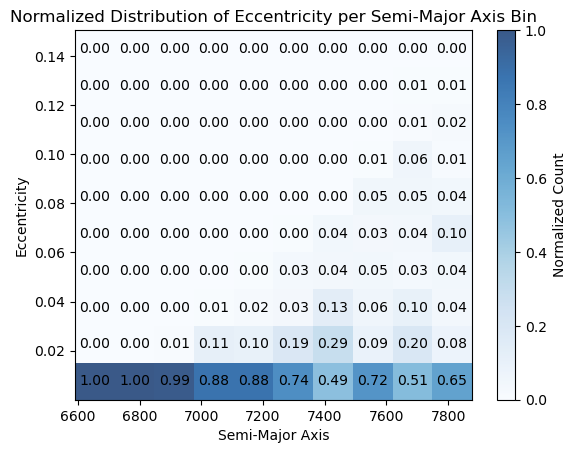

In [69]:
# Calculate the x and y values for the bins
x_bins = np.linspace(x0['sma'].min(), x0['sma'].max(), 11)
y_bins = np.linspace(x0['ecc'].min(), x0['ecc'].max(), 11)

# Calculate the 2D histogram counts
counts, xedges, yedges = np.histogram2d(x0['sma'], x0['ecc'], bins=[x_bins, y_bins])

# Normalize the counts so that each vertical column sums to 1
column_sums = counts.sum(axis=1, keepdims=True)
counts_normalized = counts / column_sums

# Handle any potential NaNs due to division by zero
counts_normalized = np.nan_to_num(counts_normalized)

# Create the heatmap for the normalized counts
plt.imshow(counts_normalized.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues', alpha=0.8)

# Add text in each bin
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), f'{counts_normalized[i, j]:.2f}', color='black', ha='center', va='center')

plt.xlabel('Semi-Major Axis')
plt.ylabel('Eccentricity')
plt.title('Normalized Distribution of Eccentricity per Semi-Major Axis Bin')
plt.colorbar(label='Normalized Count')
# no outline for each cell
plt.gca().set_facecolor('white')
plt.show()